#  目的
ベースラインの作成

ref: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification

In [50]:
# path setting
EXP_NAME = "e001-baseline"
MODEL_NAME = "microsoft/deberta-v3-base"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = f"{COMPETITION_NAME}/data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"{COMPETITION_NAME}/trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = True
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 128
SEED = 42
VALID_DATA_SIZE = 0.3
EPOCH = 1
LR = 2e-05
TRAIN_BS = 2
GRAD_ACC_NUM = 8
EVAL_BS = 2
NUM_LABELS = 6

In [2]:
!nvidia-smi

Wed May  8 22:48:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:00:05.0 Off |                  Off |
| 30%   32C    P8    27W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python --version

Python 3.11.7


In [4]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == "/notebooks":
        print("Jupyter Kernel By VSCode or nohup!")
        return base_path
    elif cwd == "/notebooks/pll_data_detection/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks
Jupyter Kernel By VSCode or nohup!
automated_essay_scoring/data
/notebooks
Jupyter Kernel By VSCode or nohup!
automated_essay_scoring/trained_models/e001-baseline


In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [48]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# import

In [7]:
import json
import os
import random

import evaluate
import numpy as np
import polars as pl
import torch
import wandb
from datasets import ClassLabel, DatasetDict, Value, concatenate_datasets, load_dataset
from tokenizers import AddedToken
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from sklearn.metrics import cohen_kappa_score

2024-05-08 22:48:37.061255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 22:48:37.061319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 22:48:37.062585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 22:48:37.069556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 22:48:38.186115: W tensorflow/compiler/tf2

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

wandb: Currently logged in as: sinchir0. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


'wandb'

# Data Import

In [13]:
train_dataset = load_dataset(
    "csv",
    data_files={"train": f"{DATA_PATH}/train.csv"},
    split="train",
)

train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score'],
    num_rows: 17307
})

In [14]:
train_dataset[1]["full_text"]

'I am a scientist at NASA that is discussing the "face" on mars. I will be explaining how the "face" is a land form. By sharing my information about this isue i will tell you just that.\n\nFirst off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this.\n\nNext, why it is a landform. There are many landforms that are weird here in America, and there is also landforms all around the whole Earth. Many of them look like something we can relate to like a snake a turtle a human... So if there are landforms on earth dont you think landforms are on mars to? Of course! why not? It\'s just unique that the landform on Mars looks like a human face. Also if there was martians and they were trying to get our attention dont y

In [15]:
if DEBUG:
    train_dataset = train_dataset.select(range(1000))

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [17]:
def preprocess_function(examples):
    return tokenizer(
        examples["full_text"],
        max_length=TRAINING_MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )

In [18]:
train_dataset = train_dataset.map(preprocess_function, batched=True, num_proc=NUM_PROC)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


In [19]:
set(train_dataset["score"])

{1, 2, 3, 4, 5, 6}

In [20]:
score2label = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

label2score = {v: k for k, v in score2label.items()}

train_dataset = train_dataset.map(
    lambda examples: {"labels": score2label[examples["score"]]},
    num_proc=NUM_PROC,
)

In [21]:
set(train_dataset["labels"])

{0, 1, 2, 3, 4, 5}

In [22]:
train_test_split_dataset = train_dataset.train_test_split(
    test_size=VALID_DATA_SIZE, seed=SEED
)
train_test_split_dataset

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'score', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 700
    })
    test: Dataset({
        features: ['essay_id', 'full_text', 'score', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
# accuracy = evaluate.load("accuracy")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=labels)


# https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800
def compute_metrics_for_classification(eval_pred):

    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights="quadratic")
    results = {"qwk": qwk}
    return results


# # TODO: 数値回帰に変更する
# def compute_metrics_for_regression(eval_pred):

#     predictions, labels = eval_pred
#     qwk = cohen_kappa_score(
#         labels, predictions.clip(0, 5).round(0), weights="quadratic"
#     )
#     results = {"qwk": qwk}
#     return results

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=score2label,
    label2id=label2score,
)

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
assert len(set(train_test_split_dataset["train"]["labels"])) == NUM_LABELS
assert len(set(train_test_split_dataset["test"]["labels"])) == NUM_LABELS

In [27]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    save_total_limit=1,
    seed=SEED,
    metric_for_best_model="qwk",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
    compute_metrics=compute_metrics_for_classification,
)

In [28]:
if TRAINING:
    # モデルの学習
    trainer.train()
    cv_score = trainer.evaluate()["eval_loss"]
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Qwk
5,No log,1.745487,0.000000
10,No log,1.646690,0.000000
15,No log,1.570614,0.000000
20,No log,1.487993,0.000000
25,No log,1.445358,0.107498
30,No log,1.422902,0.000000
35,No log,1.413545,0.000000
40,No log,1.410418,0.000000


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

# valid_datasetの作成・保存

In [29]:
def get_valid_preds(trainer):
    """
    trainerを用いてvalid_datasetに対する予測を行う
    """
    predictions = trainer.predict(trainer.eval_dataset).predictions
    preds_final = predictions.argmax(-1)

    return preds_final


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = get_valid_preds(trainer)

valid_pred = [label2score[valid] for valid in valid_pred]

np.save("valid_predictin.npy", np.array(valid_pred))

valid_dataset = trainer.eval_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

In [30]:
valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

# CVの計算

In [57]:
cv_score = cohen_kappa_score(
    valid_dataset["score"], valid_dataset["valid_pred"], weights="quadratic"
)

print(f"CV Score: {cv_score}")

# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

CV Score: 0.099445471349353


# 混同行列の計算

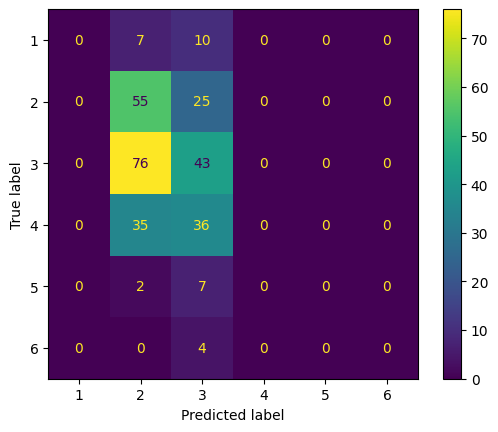

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    valid_dataset["score"], valid_dataset["valid_pred"], labels=[x for x in range(1, 7)]
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

In [52]:
MODEL_OUTPUT_PATH

'automated_essay_scoring/trained_models/e001-baseline'

# AWSへのアップロード

In [43]:
# S3へのアップロード
if UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{MODEL_OUTPUT_PATH}"
    )

rm: cannot remove '/usr/bin/aws': No such file or directory


rm: cannot remove '/usr/bin/aws_completer': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57.7M  100 57.7M    0     0   123M      0 --:--:-- --:--:-- --:--:--  123M
You can now run: /usr/local/bin/aws --version
upload: automated_essay_scoring/trained_models/e001-baseline/training_args.bin to s3://automated-essay-scoring/trained_model/automated_essay_scoring/trained_models/e001-baseline/training_args.bin
upload: automated_essay_scoring/trained_models/e001-baseline/special_tokens_map.json to s3://automated-essay-scoring/trained_model/automated_essay_scoring/trained_models/e001-baseline/special_tokens_map.json
upload: automated_essay_scoring/trained_models/e001-baseline/added_tokens.json to s3://automated-essay-scoring/trained_model/automated_essay_scoring/trained_models/e001-baseline/added_tokens.json
upload: automated_essay_scoring/trained_models/

# Kaggle Datasetへのupload

In [55]:
if UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    os.system("mkdir -p ~/.kaggle/")
    os.system(f"cp /notebooks/{COMPETITION_NAME}/kaggle.json ~/.kaggle/")
    os.system("chmod 600 ~/.kaggle/kaggle.json")

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

Create Dataset name:e001-baseline-deberta-v3-base, output_dir:automated_essay_scoring/trained_models/e001-baseline
Starting upload for file training_args.bin


  0%|          | 0.00/4.99k [00:00<?, ?B/s]

100%|██████████| 4.99k/4.99k [00:00<00:00, 16.2kB/s]


Upload successful: training_args.bin (5KB)
Starting upload for file tokenizer.json


100%|██████████| 8.26M/8.26M [00:00<00:00, 19.8MB/s]


Upload successful: tokenizer.json (8MB)
Starting upload for file confusion_matrix.png


100%|██████████| 20.2k/20.2k [00:00<00:00, 66.8kB/s]


Upload successful: confusion_matrix.png (20KB)
Starting upload for file config.json


100%|██████████| 1.04k/1.04k [00:00<00:00, 3.34kB/s]


Upload successful: config.json (1KB)
Starting upload for file valid_dataset.tar


100%|██████████| 870k/870k [00:00<00:00, 2.35MB/s]


Upload successful: valid_dataset.tar (870KB)
Starting upload for file added_tokens.json


100%|██████████| 23.0/23.0 [00:00<00:00, 72.3B/s]


Upload successful: added_tokens.json (23B)
Starting upload for file tokenizer_config.json


100%|██████████| 1.25k/1.25k [00:00<00:00, 3.70kB/s]


Upload successful: tokenizer_config.json (1KB)
Starting upload for file model.safetensors


100%|██████████| 352M/352M [00:02<00:00, 138MB/s]  


Upload successful: model.safetensors (352MB)
Starting upload for file special_tokens_map.json


100%|██████████| 286/286 [00:00<00:00, 933B/s]


Upload successful: special_tokens_map.json (286B)
Starting upload for file spm.model


100%|██████████| 2.35M/2.35M [00:00<00:00, 5.52MB/s]


Upload successful: spm.model (2MB)


# ローカルからのデータの削除

In [ ]:
if UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE:
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [ ]:
# TODO: wandbの利用 → Done
# TODO: save_modelする際にs3へ送るように変更 → Done
# TODO: valid_scoreとデータを合わせたCSVの保存 → Done
# TODO: CV計算のために、weighted kappaの実装 → Done
# TODO: Kaggle Datasetへのupload → Done
# TODO: subをする

In [ ]:
if WANDB:
    wandb.finish()